In [1]:
from utils import *

import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
import folium

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, accuracy_score

import optuna
from optuna.trial import TrialState

/home/guilhermemaciel/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Carregando o dataset

In [2]:
df_train = pd.read_csv('../data/treated_data/train.csv')
df_val = pd.read_csv('../data/treated_data/validation.csv')
df_test = pd.read_csv('../data/treated_data/test.csv')

Concatenando os datasets de treino e validação, pois o Random Forest não necessita de validação

In [3]:
df_train = pd.concat([df_train, df_val], ignore_index=False)

In [4]:
df_train.head()

ponto_id  rssi_1_1  rssi_1_2  rssi_1_3  rssi_2_1  rssi_2_2  rssi_2_3  \
0      8790  0.559200  0.398652  0.703014  0.267376  0.426916  0.454187   
1      3227  0.246700  0.000000  0.332592  0.000000  0.360645  0.342995   
2      4180  0.184200  0.000000  0.168521  0.145990  0.318269  0.288125   
3      8922  0.707155  0.446022  0.718534  0.490706  0.361142  0.451422   
4      1117  0.121940  0.157226  0.161643  0.088497  0.252093  0.256320   

   rssi_3_1  rssi_3_2  rssi_3_3   delay_1   delay_2   delay_3       lat  \
0  0.317280  0.311331  0.301273  0.333333  0.571429  0.428571 -8.050090   
1  0.169190  0.339785  0.000000  0.666667  0.428571  0.428571 -8.055834   
2  0.175386  0.277219  0.000000  0.666667  0.428571  0.285714 -8.055424   
3  0.326812  0.331300  0.299672  0.166667  0.571429  0.428571 -8.049530   
4  0.087576  0.252854  0.000000  0.666667  0.428571  0.285714 -8.055380   

         lon  indoor  
0 -34.953120       0  
1 -34.951362       1  
2 -34.951597       1  
3 -34.953290       0  
4 -34.951736       1

In [5]:
X_train = df_train.drop(['ponto_id', 'indoor', 'lat', 'lon'], axis=1).values
y_train = df_train[['lat', 'lon']].values

X_test = df_test.drop(['ponto_id', 'indoor', 'lat', 'lon'], axis=1).values
y_test = df_test[['lat', 'lon']].values

In [6]:
model = RandomForestRegressor(
    n_estimators=10,
    max_depth=10,
    criterion='squared_error',
    min_samples_leaf=1,
    max_features=df_train.shape[1],
    random_state=51
)

In [7]:
model.fit(X=X_train, y=y_train)

RandomForestRegressor(max_depth=10, max_features=16, n_estimators=10,
                      random_state=51)

## Avaliando o modelo

#### Conjunto de Teste

In [8]:
y_pred_test_class = model.predict(X_test)

rmse = np.sqrt(root_mean_squared_error(y_test, y_pred_test_class))
print(f'RMSE: {rmse}')

RMSE: 0.011067194062577203


In [9]:
accuracy = calculate_accuracy(y_pred_test_class, y_test)
print(f"Acurácia: {accuracy:.3f}")


Acurácia: 0.827


Erro de localização médio, mínimo, máximo e desvio-padrão

In [10]:
distances = get_error_distances(y_pred_test_class, y_test)

In [11]:
print_errors(distances)

Erro de localização médio: 6.898 metros
Erro mínimo: 7.223231439955147e-10 metros
Erro máximo: 217.751 metros
Desvio Padrão do erro: 17.902 metros


#### BoxPlot

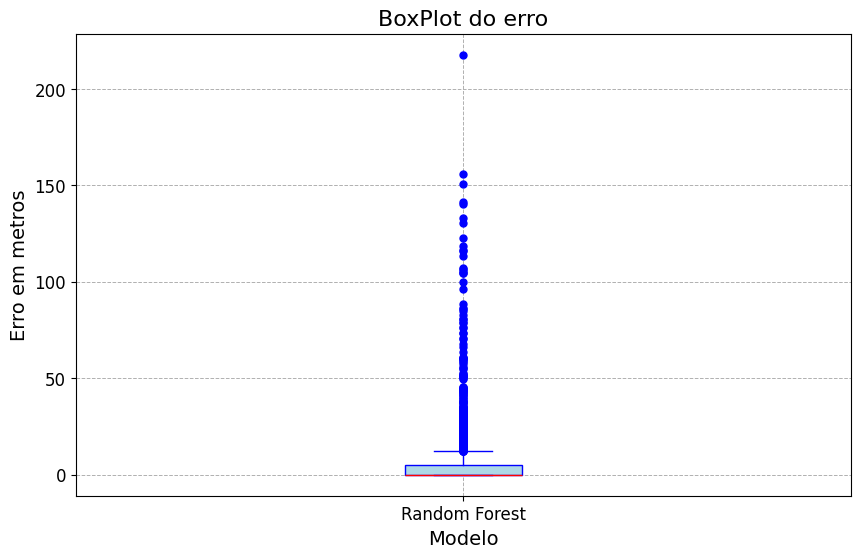

In [12]:
plot_boxplot('Random Forest', distances)

#### Visualização dos Mapas

In [13]:
map = plot_folium_map(y_test, y_pred_test_class, True)
map

In [14]:
map = plot_folium_map(y_test, y_pred_test_class, False)
map

#### Avaliando o modelos para pontos específicos 

In [15]:
# Prevendo o valor de uma instância específica
idx = 75

X_unit = X_test[idx].reshape(1, -1)
y_unit = np.array([y_test[idx]])
y_pred_unit = model.predict(X_unit)

print(f"Pred Point: {y_pred_unit[0]}")
print(f"Real Point: {y_unit[0]}")

Pred Point: [ -8.055786 -34.951505]
Real Point: [ -8.055786 -34.951505]


In [16]:
map = plot_folium_map(y_unit, y_pred_unit, True)
map

#### Usando o Optune para encontrar os melhores Hiperparâmetros

#### Primeiro iremos criar uma função objetivo, com foco em maximizar o AOC

In [17]:
def objective(trial):

    global x_train
    global y_train

    global X_test
    global y_test
    
    # Sugerir valores para os hiperparâmetros
    n_estimators = trial.suggest_int('n_estimators', 10, 500)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    trial.set_user_attr("n_estimators", n_estimators)
    trial.set_user_attr("max_depth", max_depth)
    trial.set_user_attr("min_samples_split", min_samples_split)
    trial.set_user_attr("min_samples_leaf", min_samples_leaf)
    
    # Criar o modelo RandomForest com os hiperparâmetros sugeridos
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=51,
        criterion='squared_error',
    )

    model.fit(X=X_train, y=y_train)
    
    # Avaliar o modelo usando test k-s
    y_pred_test_class = model.predict(X_test)
    rmse = np.sqrt(root_mean_squared_error(y_test, y_pred_test_class))
    accuracy = calculate_accuracy(y_pred_test_class, y_test)
    
    print(f'\n\nRandom Forest\nn_estimators: {n_estimators}\nmax_depth:{max_depth}\nmin_samples_split:{min_samples_split}\nmin_samples_leaf:{min_samples_leaf}')
    print(f'RMSE: {rmse}\nAccuracy: {accuracy:.3f}')
    

    trial.set_user_attr("RMSE", rmse)
    trial.set_user_attr("Accuracy", accuracy)
    
    return rmse


In [18]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2024-07-31 22:40:32,126] A new study created in memory with name: no-name-76375ebc-c3c5-4777-b17b-046ec2e37620
[I 2024-07-31 22:40:34,142] Trial 0 finished with value: 0.01087355731811091 and parameters: {'n_estimators': 142, 'max_depth': 17, 'min_samples_split': 12, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.01087355731811091.




Random Forest
n_estimators: 142
max_depth:17
min_samples_split:12
min_samples_leaf:5
RMSE: 0.01087355731811091
Accuracy: 0.819


[I 2024-07-31 22:40:36,921] Trial 1 finished with value: 0.01067499207607903 and parameters: {'n_estimators': 194, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.01067499207607903.




Random Forest
n_estimators: 194
max_depth:14
min_samples_split:6
min_samples_leaf:4
RMSE: 0.01067499207607903
Accuracy: 0.826


[I 2024-07-31 22:40:42,114] Trial 2 finished with value: 0.011581983555350011 and parameters: {'n_estimators': 406, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.01067499207607903.




Random Forest
n_estimators: 406
max_depth:20
min_samples_split:8
min_samples_leaf:10
RMSE: 0.011581983555350011
Accuracy: 0.786


[I 2024-07-31 22:40:42,955] Trial 3 finished with value: 0.018990363733332863 and parameters: {'n_estimators': 94, 'max_depth': 5, 'min_samples_split': 13, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.01067499207607903.




Random Forest
n_estimators: 94
max_depth:5
min_samples_split:13
min_samples_leaf:2
RMSE: 0.018990363733332863
Accuracy: 0.009


[I 2024-07-31 22:40:45,124] Trial 4 finished with value: 0.013291455045207751 and parameters: {'n_estimators': 190, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.01067499207607903.




Random Forest
n_estimators: 190
max_depth:7
min_samples_split:4
min_samples_leaf:6
RMSE: 0.013291455045207751
Accuracy: 0.288


[I 2024-07-31 22:40:50,502] Trial 5 finished with value: 0.011602256022148653 and parameters: {'n_estimators': 418, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.01067499207607903.




Random Forest
n_estimators: 418
max_depth:13
min_samples_split:4
min_samples_leaf:10
RMSE: 0.011602256022148653
Accuracy: 0.784


[I 2024-07-31 22:40:53,163] Trial 6 finished with value: 0.011344385698272362 and parameters: {'n_estimators': 210, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.01067499207607903.
[I 2024-07-31 22:40:53,291] Trial 7 finished with value: 0.011968080002027962 and parameters: {'n_estimators': 10, 'max_depth': 13, 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.01067499207607903.




Random Forest
n_estimators: 210
max_depth:19
min_samples_split:2
min_samples_leaf:9
RMSE: 0.011344385698272362
Accuracy: 0.789


Random Forest
n_estimators: 10
max_depth:13
min_samples_split:9
min_samples_leaf:10
RMSE: 0.011968080002027962
Accuracy: 0.779


[I 2024-07-31 22:40:57,617] Trial 8 finished with value: 0.010550882629037788 and parameters: {'n_estimators': 316, 'max_depth': 18, 'min_samples_split': 12, 'min_samples_leaf': 2}. Best is trial 8 with value: 0.010550882629037788.




Random Forest
n_estimators: 316
max_depth:18
min_samples_split:12
min_samples_leaf:2
RMSE: 0.010550882629037788
Accuracy: 0.824


[I 2024-07-31 22:40:58,906] Trial 9 finished with value: 0.011871919501719163 and parameters: {'n_estimators': 108, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 8 with value: 0.010550882629037788.




Random Forest
n_estimators: 108
max_depth:8
min_samples_split:8
min_samples_leaf:3
RMSE: 0.011871919501719163
Accuracy: 0.550


[I 2024-07-31 22:41:03,490] Trial 10 finished with value: 0.010662652245889633 and parameters: {'n_estimators': 325, 'max_depth': 16, 'min_samples_split': 15, 'min_samples_leaf': 1}. Best is trial 8 with value: 0.010550882629037788.




Random Forest
n_estimators: 325
max_depth:16
min_samples_split:15
min_samples_leaf:1
RMSE: 0.010662652245889633
Accuracy: 0.812


[I 2024-07-31 22:41:08,162] Trial 11 finished with value: 0.010659160312628419 and parameters: {'n_estimators': 329, 'max_depth': 16, 'min_samples_split': 15, 'min_samples_leaf': 1}. Best is trial 8 with value: 0.010550882629037788.




Random Forest
n_estimators: 329
max_depth:16
min_samples_split:15
min_samples_leaf:1
RMSE: 0.010659160312628419
Accuracy: 0.812


[I 2024-07-31 22:41:12,447] Trial 12 finished with value: 0.010670837122373924 and parameters: {'n_estimators': 306, 'max_depth': 17, 'min_samples_split': 15, 'min_samples_leaf': 1}. Best is trial 8 with value: 0.010550882629037788.




Random Forest
n_estimators: 306
max_depth:17
min_samples_split:15
min_samples_leaf:1
RMSE: 0.010670837122373924
Accuracy: 0.811


[I 2024-07-31 22:41:18,914] Trial 13 finished with value: 0.010753313072789929 and parameters: {'n_estimators': 480, 'max_depth': 10, 'min_samples_split': 12, 'min_samples_leaf': 3}. Best is trial 8 with value: 0.010550882629037788.




Random Forest
n_estimators: 480
max_depth:10
min_samples_split:12
min_samples_leaf:3
RMSE: 0.010753313072789929
Accuracy: 0.811


[I 2024-07-31 22:41:23,001] Trial 14 finished with value: 0.010996532550046813 and parameters: {'n_estimators': 299, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 8 with value: 0.010550882629037788.




Random Forest
n_estimators: 299
max_depth:15
min_samples_split:10
min_samples_leaf:7
RMSE: 0.010996532550046813
Accuracy: 0.809


[I 2024-07-31 22:41:27,900] Trial 15 finished with value: 0.010610315643588908 and parameters: {'n_estimators': 357, 'max_depth': 18, 'min_samples_split': 13, 'min_samples_leaf': 2}. Best is trial 8 with value: 0.010550882629037788.




Random Forest
n_estimators: 357
max_depth:18
min_samples_split:13
min_samples_leaf:2
RMSE: 0.010610315643588908
Accuracy: 0.818


[I 2024-07-31 22:41:33,217] Trial 16 finished with value: 0.010784461970746619 and parameters: {'n_estimators': 394, 'max_depth': 19, 'min_samples_split': 13, 'min_samples_leaf': 3}. Best is trial 8 with value: 0.010550882629037788.




Random Forest
n_estimators: 394
max_depth:19
min_samples_split:13
min_samples_leaf:3
RMSE: 0.010784461970746619
Accuracy: 0.815


[I 2024-07-31 22:41:39,466] Trial 17 finished with value: 0.010780323163782605 and parameters: {'n_estimators': 474, 'max_depth': 11, 'min_samples_split': 11, 'min_samples_leaf': 5}. Best is trial 8 with value: 0.010550882629037788.




Random Forest
n_estimators: 474
max_depth:11
min_samples_split:11
min_samples_leaf:5
RMSE: 0.010780323163782605
Accuracy: 0.821


[I 2024-07-31 22:41:42,739] Trial 18 finished with value: 0.01099433492277908 and parameters: {'n_estimators': 253, 'max_depth': 18, 'min_samples_split': 13, 'min_samples_leaf': 7}. Best is trial 8 with value: 0.010550882629037788.




Random Forest
n_estimators: 253
max_depth:18
min_samples_split:13
min_samples_leaf:7
RMSE: 0.01099433492277908
Accuracy: 0.809


[I 2024-07-31 22:41:47,684] Trial 19 finished with value: 0.010438262127611127 and parameters: {'n_estimators': 353, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 19 with value: 0.010438262127611127.




Random Forest
n_estimators: 353
max_depth:20
min_samples_split:10
min_samples_leaf:2
RMSE: 0.010438262127611127
Accuracy: 0.831


[I 2024-07-31 22:41:51,201] Trial 20 finished with value: 0.010662860607740519 and parameters: {'n_estimators': 254, 'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 19 with value: 0.010438262127611127.




Random Forest
n_estimators: 254
max_depth:20
min_samples_split:7
min_samples_leaf:4
RMSE: 0.010662860607740519
Accuracy: 0.829


[I 2024-07-31 22:41:56,500] Trial 21 finished with value: 0.010430471555118913 and parameters: {'n_estimators': 381, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.010430471555118913.




Random Forest
n_estimators: 381
max_depth:18
min_samples_split:10
min_samples_leaf:2
RMSE: 0.010430471555118913
Accuracy: 0.830


[I 2024-07-31 22:42:02,063] Trial 22 finished with value: 0.010434899965346297 and parameters: {'n_estimators': 386, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.010430471555118913.




Random Forest
n_estimators: 386
max_depth:20
min_samples_split:10
min_samples_leaf:2
RMSE: 0.010434899965346297
Accuracy: 0.828


[I 2024-07-31 22:42:07,353] Trial 23 finished with value: 0.010719039124556793 and parameters: {'n_estimators': 362, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 21 with value: 0.010430471555118913.




Random Forest
n_estimators: 362
max_depth:20
min_samples_split:10
min_samples_leaf:4
RMSE: 0.010719039124556793
Accuracy: 0.825


[I 2024-07-31 22:42:10,173] Trial 24 finished with value: 0.028336425669159688 and parameters: {'n_estimators': 447, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.010430471555118913.




Random Forest
n_estimators: 447
max_depth:3
min_samples_split:10
min_samples_leaf:2
RMSE: 0.028336425669159688
Accuracy: 0.149


[I 2024-07-31 22:42:15,582] Trial 25 finished with value: 0.010493088441076073 and parameters: {'n_estimators': 375, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.010430471555118913.




Random Forest
n_estimators: 375
max_depth:20
min_samples_split:6
min_samples_leaf:3
RMSE: 0.010493088441076073
Accuracy: 0.833


[I 2024-07-31 22:42:21,299] Trial 26 finished with value: 0.010333741188258883 and parameters: {'n_estimators': 412, 'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 26 with value: 0.010333741188258883.




Random Forest
n_estimators: 412
max_depth:16
min_samples_split:9
min_samples_leaf:1
RMSE: 0.010333741188258883
Accuracy: 0.830


[I 2024-07-31 22:42:27,368] Trial 27 finished with value: 0.010342892529509312 and parameters: {'n_estimators': 436, 'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 26 with value: 0.010333741188258883.




Random Forest
n_estimators: 436
max_depth:15
min_samples_split:9
min_samples_leaf:1
RMSE: 0.010342892529509312
Accuracy: 0.831


[I 2024-07-31 22:42:33,813] Trial 28 finished with value: 0.010265741768333642 and parameters: {'n_estimators': 432, 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 28 with value: 0.010265741768333642.




Random Forest
n_estimators: 432
max_depth:14
min_samples_split:7
min_samples_leaf:1
RMSE: 0.010265741768333642
Accuracy: 0.841


[I 2024-07-31 22:42:40,299] Trial 29 finished with value: 0.010268168844074428 and parameters: {'n_estimators': 448, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 28 with value: 0.010265741768333642.




Random Forest
n_estimators: 448
max_depth:13
min_samples_split:7
min_samples_leaf:1
RMSE: 0.010268168844074428
Accuracy: 0.840


[I 2024-07-31 22:42:47,074] Trial 30 finished with value: 0.0101887288332515 and parameters: {'n_estimators': 459, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 30 with value: 0.0101887288332515.




Random Forest
n_estimators: 459
max_depth:12
min_samples_split:6
min_samples_leaf:1
RMSE: 0.0101887288332515
Accuracy: 0.845


[I 2024-07-31 22:42:54,462] Trial 31 finished with value: 0.010192180155533507 and parameters: {'n_estimators': 497, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 30 with value: 0.0101887288332515.




Random Forest
n_estimators: 497
max_depth:12
min_samples_split:6
min_samples_leaf:1
RMSE: 0.010192180155533507
Accuracy: 0.845


[I 2024-07-31 22:43:01,710] Trial 32 finished with value: 0.010192180155533507 and parameters: {'n_estimators': 497, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 30 with value: 0.0101887288332515.




Random Forest
n_estimators: 497
max_depth:12
min_samples_split:6
min_samples_leaf:1
RMSE: 0.010192180155533507
Accuracy: 0.845


[I 2024-07-31 22:43:08,412] Trial 33 finished with value: 0.010271296387633447 and parameters: {'n_estimators': 491, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 30 with value: 0.0101887288332515.




Random Forest
n_estimators: 491
max_depth:10
min_samples_split:5
min_samples_leaf:1
RMSE: 0.010271296387633447
Accuracy: 0.835


[I 2024-07-31 22:43:15,066] Trial 34 finished with value: 0.01067442499370941 and parameters: {'n_estimators': 493, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 30 with value: 0.0101887288332515.




Random Forest
n_estimators: 493
max_depth:12
min_samples_split:6
min_samples_leaf:4
RMSE: 0.01067442499370941
Accuracy: 0.830


[I 2024-07-31 22:43:20,958] Trial 35 finished with value: 0.010833885980918211 and parameters: {'n_estimators': 455, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 30 with value: 0.0101887288332515.




Random Forest
n_estimators: 455
max_depth:9
min_samples_split:5
min_samples_leaf:3
RMSE: 0.010833885980918211
Accuracy: 0.801


[I 2024-07-31 22:43:28,799] Trial 36 finished with value: 0.01016479070835762 and parameters: {'n_estimators': 499, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 36 with value: 0.01016479070835762.




Random Forest
n_estimators: 499
max_depth:12
min_samples_split:3
min_samples_leaf:1
RMSE: 0.01016479070835762
Accuracy: 0.851


[I 2024-07-31 22:43:36,115] Trial 37 finished with value: 0.010282879906200996 and parameters: {'n_estimators': 497, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.01016479070835762.




Random Forest
n_estimators: 497
max_depth:11
min_samples_split:2
min_samples_leaf:2
RMSE: 0.010282879906200996
Accuracy: 0.847


[I 2024-07-31 22:43:42,447] Trial 38 finished with value: 0.011182189768602009 and parameters: {'n_estimators': 469, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 8}. Best is trial 36 with value: 0.01016479070835762.




Random Forest
n_estimators: 469
max_depth:12
min_samples_split:4
min_samples_leaf:8
RMSE: 0.011182189768602009
Accuracy: 0.799


[I 2024-07-31 22:43:47,456] Trial 39 finished with value: 0.013102004594812968 and parameters: {'n_estimators': 423, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.01016479070835762.




Random Forest
n_estimators: 423
max_depth:7
min_samples_split:3
min_samples_leaf:2
RMSE: 0.013102004594812968
Accuracy: 0.288


[I 2024-07-31 22:43:53,803] Trial 40 finished with value: 0.010888711937841628 and parameters: {'n_estimators': 460, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 36 with value: 0.01016479070835762.




Random Forest
n_estimators: 460
max_depth:14
min_samples_split:5
min_samples_leaf:6
RMSE: 0.010888711937841628
Accuracy: 0.819


[I 2024-07-31 22:44:00,311] Trial 41 finished with value: 0.010262800556985299 and parameters: {'n_estimators': 427, 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 36 with value: 0.01016479070835762.




Random Forest
n_estimators: 427
max_depth:14
min_samples_split:7
min_samples_leaf:1
RMSE: 0.010262800556985299
Accuracy: 0.841


[I 2024-07-31 22:44:07,777] Trial 42 finished with value: 0.010313120242756824 and parameters: {'n_estimators': 500, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 36 with value: 0.01016479070835762.




Random Forest
n_estimators: 500
max_depth:13
min_samples_split:8
min_samples_leaf:1
RMSE: 0.010313120242756824
Accuracy: 0.837


[I 2024-07-31 22:44:13,880] Trial 43 finished with value: 0.01026266472514155 and parameters: {'n_estimators': 411, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 36 with value: 0.01016479070835762.




Random Forest
n_estimators: 411
max_depth:10
min_samples_split:3
min_samples_leaf:1
RMSE: 0.01026266472514155
Accuracy: 0.837


[I 2024-07-31 22:44:19,719] Trial 44 finished with value: 0.010558316110898225 and parameters: {'n_estimators': 407, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 36 with value: 0.01016479070835762.




Random Forest
n_estimators: 407
max_depth:10
min_samples_split:3
min_samples_leaf:3
RMSE: 0.010558316110898225
Accuracy: 0.828


[I 2024-07-31 22:44:26,340] Trial 45 finished with value: 0.010552536870704413 and parameters: {'n_estimators': 475, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 36 with value: 0.01016479070835762.




Random Forest
n_estimators: 475
max_depth:9
min_samples_split:3
min_samples_leaf:1
RMSE: 0.010552536870704413
Accuracy: 0.811


[I 2024-07-31 22:44:26,874] Trial 46 finished with value: 0.010487278694225298 and parameters: {'n_estimators': 32, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.01016479070835762.




Random Forest
n_estimators: 32
max_depth:12
min_samples_split:4
min_samples_leaf:2
RMSE: 0.010487278694225298
Accuracy: 0.842


[I 2024-07-31 22:44:29,612] Trial 47 finished with value: 0.010193536254808944 and parameters: {'n_estimators': 173, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 36 with value: 0.01016479070835762.




Random Forest
n_estimators: 173
max_depth:11
min_samples_split:2
min_samples_leaf:1
RMSE: 0.010193536254808944
Accuracy: 0.847


[I 2024-07-31 22:44:32,210] Trial 48 finished with value: 0.010351411157440394 and parameters: {'n_estimators': 167, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.01016479070835762.




Random Forest
n_estimators: 167
max_depth:11
min_samples_split:2
min_samples_leaf:2
RMSE: 0.010351411157440394
Accuracy: 0.842


[I 2024-07-31 22:44:35,394] Trial 49 finished with value: 0.010518785927818417 and parameters: {'n_estimators': 197, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 36 with value: 0.01016479070835762.




Random Forest
n_estimators: 197
max_depth:13
min_samples_split:5
min_samples_leaf:3
RMSE: 0.010518785927818417
Accuracy: 0.834


[I 2024-07-31 22:44:37,014] Trial 50 finished with value: 0.010695393857479387 and parameters: {'n_estimators': 117, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.01016479070835762.




Random Forest
n_estimators: 117
max_depth:9
min_samples_split:4
min_samples_leaf:2
RMSE: 0.010695393857479387
Accuracy: 0.803


[I 2024-07-31 22:44:40,726] Trial 51 finished with value: 0.010160100980934877 and parameters: {'n_estimators': 234, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 51 with value: 0.010160100980934877.




Random Forest
n_estimators: 234
max_depth:11
min_samples_split:2
min_samples_leaf:1
RMSE: 0.010160100980934877
Accuracy: 0.848


[I 2024-07-31 22:44:44,390] Trial 52 finished with value: 0.010142785400837276 and parameters: {'n_estimators': 225, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 52 with value: 0.010142785400837276.




Random Forest
n_estimators: 225
max_depth:12
min_samples_split:2
min_samples_leaf:1
RMSE: 0.010142785400837276
Accuracy: 0.852


[I 2024-07-31 22:44:47,750] Trial 53 finished with value: 0.010160525113331141 and parameters: {'n_estimators': 227, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 52 with value: 0.010142785400837276.




Random Forest
n_estimators: 227
max_depth:12
min_samples_split:6
min_samples_leaf:1
RMSE: 0.010160525113331141
Accuracy: 0.844


[I 2024-07-31 22:44:51,393] Trial 54 finished with value: 0.01014710984032043 and parameters: {'n_estimators': 233, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 52 with value: 0.010142785400837276.




Random Forest
n_estimators: 233
max_depth:13
min_samples_split:2
min_samples_leaf:1
RMSE: 0.01014710984032043
Accuracy: 0.849


[I 2024-07-31 22:44:54,730] Trial 55 finished with value: 0.010288791866082872 and parameters: {'n_estimators': 225, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 52 with value: 0.010142785400837276.




Random Forest
n_estimators: 225
max_depth:15
min_samples_split:2
min_samples_leaf:2
RMSE: 0.010288791866082872
Accuracy: 0.848


[I 2024-07-31 22:44:57,662] Trial 56 finished with value: 0.011352114111064722 and parameters: {'n_estimators': 227, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 52 with value: 0.010142785400837276.




Random Forest
n_estimators: 227
max_depth:13
min_samples_split:3
min_samples_leaf:9
RMSE: 0.011352114111064722
Accuracy: 0.788


[I 2024-07-31 22:45:01,488] Trial 57 finished with value: 0.01168773377677444 and parameters: {'n_estimators': 284, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 52 with value: 0.010142785400837276.




Random Forest
n_estimators: 284
max_depth:8
min_samples_split:4
min_samples_leaf:2
RMSE: 0.01168773377677444
Accuracy: 0.618


[I 2024-07-31 22:45:05,884] Trial 58 finished with value: 0.010185114679424694 and parameters: {'n_estimators': 273, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 52 with value: 0.010142785400837276.




Random Forest
n_estimators: 273
max_depth:14
min_samples_split:2
min_samples_leaf:1
RMSE: 0.010185114679424694
Accuracy: 0.849


[I 2024-07-31 22:45:10,270] Trial 59 finished with value: 0.010264823355758186 and parameters: {'n_estimators': 287, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 52 with value: 0.010142785400837276.




Random Forest
n_estimators: 287
max_depth:14
min_samples_split:2
min_samples_leaf:2
RMSE: 0.010264823355758186
Accuracy: 0.848


[I 2024-07-31 22:45:13,653] Trial 60 finished with value: 0.010506077398045963 and parameters: {'n_estimators': 237, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.010142785400837276.




Random Forest
n_estimators: 237
max_depth:11
min_samples_split:3
min_samples_leaf:3
RMSE: 0.010506077398045963
Accuracy: 0.835


[I 2024-07-31 22:45:17,976] Trial 61 finished with value: 0.010189383012980932 and parameters: {'n_estimators': 268, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 52 with value: 0.010142785400837276.




Random Forest
n_estimators: 268
max_depth:14
min_samples_split:2
min_samples_leaf:1
RMSE: 0.010189383012980932
Accuracy: 0.850


[I 2024-07-31 22:45:21,257] Trial 62 finished with value: 0.010133484362701346 and parameters: {'n_estimators': 207, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 62 with value: 0.010133484362701346.




Random Forest
n_estimators: 207
max_depth:13
min_samples_split:2
min_samples_leaf:1
RMSE: 0.010133484362701346
Accuracy: 0.850


[I 2024-07-31 22:45:24,717] Trial 63 finished with value: 0.010125045956191032 and parameters: {'n_estimators': 210, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 63 with value: 0.010125045956191032.




Random Forest
n_estimators: 210
max_depth:15
min_samples_split:2
min_samples_leaf:1
RMSE: 0.010125045956191032
Accuracy: 0.850


[I 2024-07-31 22:45:27,875] Trial 64 finished with value: 0.010263528892007238 and parameters: {'n_estimators': 207, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 63 with value: 0.010125045956191032.




Random Forest
n_estimators: 207
max_depth:13
min_samples_split:3
min_samples_leaf:2
RMSE: 0.010263528892007238
Accuracy: 0.847


[I 2024-07-31 22:45:30,783] Trial 65 finished with value: 0.010178829061209125 and parameters: {'n_estimators': 176, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 63 with value: 0.010125045956191032.




Random Forest
n_estimators: 176
max_depth:16
min_samples_split:2
min_samples_leaf:1
RMSE: 0.010178829061209125
Accuracy: 0.849


[I 2024-07-31 22:45:33,120] Trial 66 finished with value: 0.010188828527288434 and parameters: {'n_estimators': 143, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 63 with value: 0.010125045956191032.




Random Forest
n_estimators: 143
max_depth:15
min_samples_split:3
min_samples_leaf:1
RMSE: 0.010188828527288434
Accuracy: 0.848


[I 2024-07-31 22:45:36,906] Trial 67 finished with value: 0.01014137389626028 and parameters: {'n_estimators': 238, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 63 with value: 0.010125045956191032.




Random Forest
n_estimators: 238
max_depth:13
min_samples_split:2
min_samples_leaf:1
RMSE: 0.01014137389626028
Accuracy: 0.850


[I 2024-07-31 22:45:40,541] Trial 68 finished with value: 0.01026688895309346 and parameters: {'n_estimators': 238, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 63 with value: 0.010125045956191032.




Random Forest
n_estimators: 238
max_depth:17
min_samples_split:4
min_samples_leaf:2
RMSE: 0.01026688895309346
Accuracy: 0.845


[I 2024-07-31 22:45:43,447] Trial 69 finished with value: 0.010874616205966171 and parameters: {'n_estimators': 213, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 63 with value: 0.010125045956191032.




Random Forest
n_estimators: 213
max_depth:15
min_samples_split:2
min_samples_leaf:6
RMSE: 0.010874616205966171
Accuracy: 0.817


[I 2024-07-31 22:45:46,476] Trial 70 finished with value: 0.010152520477140735 and parameters: {'n_estimators': 186, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 63 with value: 0.010125045956191032.




Random Forest
n_estimators: 186
max_depth:13
min_samples_split:2
min_samples_leaf:1
RMSE: 0.010152520477140735
Accuracy: 0.848


[I 2024-07-31 22:45:49,390] Trial 71 finished with value: 0.010167553089027219 and parameters: {'n_estimators': 191, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 63 with value: 0.010125045956191032.




Random Forest
n_estimators: 191
max_depth:11
min_samples_split:2
min_samples_leaf:1
RMSE: 0.010167553089027219
Accuracy: 0.847


[I 2024-07-31 22:45:51,778] Trial 72 finished with value: 0.010188470765697248 and parameters: {'n_estimators': 148, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 63 with value: 0.010125045956191032.




Random Forest
n_estimators: 148
max_depth:13
min_samples_split:2
min_samples_leaf:1
RMSE: 0.010188470765697248
Accuracy: 0.848


[I 2024-07-31 22:45:55,731] Trial 73 finished with value: 0.010121804175326292 and parameters: {'n_estimators': 251, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 73 with value: 0.010121804175326292.




Random Forest
n_estimators: 251
max_depth:13
min_samples_split:3
min_samples_leaf:1
RMSE: 0.010121804175326292
Accuracy: 0.851


[I 2024-07-31 22:45:59,580] Trial 74 finished with value: 0.010266501105242265 and parameters: {'n_estimators': 252, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 73 with value: 0.010121804175326292.




Random Forest
n_estimators: 252
max_depth:16
min_samples_split:3
min_samples_leaf:2
RMSE: 0.010266501105242265
Accuracy: 0.848


[I 2024-07-31 22:46:02,951] Trial 75 finished with value: 0.010138107354388026 and parameters: {'n_estimators': 209, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 73 with value: 0.010121804175326292.




Random Forest
n_estimators: 209
max_depth:13
min_samples_split:2
min_samples_leaf:1
RMSE: 0.010138107354388026
Accuracy: 0.850


[I 2024-07-31 22:46:06,123] Trial 76 finished with value: 0.010261134624641148 and parameters: {'n_estimators': 209, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 73 with value: 0.010121804175326292.




Random Forest
n_estimators: 209
max_depth:13
min_samples_split:3
min_samples_leaf:2
RMSE: 0.010261134624641148
Accuracy: 0.848


[I 2024-07-31 22:46:09,644] Trial 77 finished with value: 0.010747124766624575 and parameters: {'n_estimators': 255, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 73 with value: 0.010121804175326292.




Random Forest
n_estimators: 255
max_depth:15
min_samples_split:4
min_samples_leaf:5
RMSE: 0.010747124766624575
Accuracy: 0.823


[I 2024-07-31 22:46:12,596] Trial 78 finished with value: 0.010213953016013157 and parameters: {'n_estimators': 182, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 73 with value: 0.010121804175326292.




Random Forest
n_estimators: 182
max_depth:14
min_samples_split:2
min_samples_leaf:1
RMSE: 0.010213953016013157
Accuracy: 0.851


[I 2024-07-31 22:46:15,771] Trial 79 finished with value: 0.010123667878722943 and parameters: {'n_estimators': 199, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 73 with value: 0.010121804175326292.




Random Forest
n_estimators: 199
max_depth:13
min_samples_split:3
min_samples_leaf:1
RMSE: 0.010123667878722943
Accuracy: 0.850


[I 2024-07-31 22:46:18,002] Trial 80 finished with value: 0.01102352843455903 and parameters: {'n_estimators': 163, 'max_depth': 17, 'min_samples_split': 14, 'min_samples_leaf': 7}. Best is trial 73 with value: 0.010121804175326292.




Random Forest
n_estimators: 163
max_depth:17
min_samples_split:14
min_samples_leaf:7
RMSE: 0.01102352843455903
Accuracy: 0.807


[I 2024-07-31 22:46:21,119] Trial 81 finished with value: 0.01012538836965942 and parameters: {'n_estimators': 198, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 73 with value: 0.010121804175326292.




Random Forest
n_estimators: 198
max_depth:13
min_samples_split:3
min_samples_leaf:1
RMSE: 0.01012538836965942
Accuracy: 0.850


[I 2024-07-31 22:46:24,305] Trial 82 finished with value: 0.010148826403513788 and parameters: {'n_estimators': 199, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 73 with value: 0.010121804175326292.




Random Forest
n_estimators: 199
max_depth:14
min_samples_split:3
min_samples_leaf:1
RMSE: 0.010148826403513788
Accuracy: 0.854


[I 2024-07-31 22:46:27,761] Trial 83 finished with value: 0.010121485348331483 and parameters: {'n_estimators': 215, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 83 with value: 0.010121485348331483.




Random Forest
n_estimators: 215
max_depth:13
min_samples_split:3
min_samples_leaf:1
RMSE: 0.010121485348331483
Accuracy: 0.850


[I 2024-07-31 22:46:30,208] Trial 84 finished with value: 0.010234175957197906 and parameters: {'n_estimators': 154, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 83 with value: 0.010121485348331483.




Random Forest
n_estimators: 154
max_depth:12
min_samples_split:3
min_samples_leaf:1
RMSE: 0.010234175957197906
Accuracy: 0.850


[I 2024-07-31 22:46:33,534] Trial 85 finished with value: 0.010258088299176895 and parameters: {'n_estimators': 215, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 83 with value: 0.010121485348331483.




Random Forest
n_estimators: 215
max_depth:13
min_samples_split:4
min_samples_leaf:2
RMSE: 0.010258088299176895
Accuracy: 0.848


[I 2024-07-31 22:46:38,327] Trial 86 finished with value: 0.01012124407696109 and parameters: {'n_estimators': 311, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 86 with value: 0.01012124407696109.




Random Forest
n_estimators: 311
max_depth:15
min_samples_split:4
min_samples_leaf:1
RMSE: 0.01012124407696109
Accuracy: 0.848


[I 2024-07-31 22:46:43,182] Trial 87 finished with value: 0.01024483797356434 and parameters: {'n_estimators': 326, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 86 with value: 0.01012124407696109.




Random Forest
n_estimators: 326
max_depth:15
min_samples_split:5
min_samples_leaf:2
RMSE: 0.01024483797356434
Accuracy: 0.846


[I 2024-07-31 22:46:45,171] Trial 88 finished with value: 0.010336836453189358 and parameters: {'n_estimators': 127, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 86 with value: 0.01012124407696109.




Random Forest
n_estimators: 127
max_depth:14
min_samples_split:4
min_samples_leaf:2
RMSE: 0.010336836453189358
Accuracy: 0.841


[I 2024-07-31 22:46:49,418] Trial 89 finished with value: 0.010161749966410255 and parameters: {'n_estimators': 268, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 86 with value: 0.01012124407696109.




Random Forest
n_estimators: 268
max_depth:15
min_samples_split:3
min_samples_leaf:1
RMSE: 0.010161749966410255
Accuracy: 0.850


[I 2024-07-31 22:46:54,190] Trial 90 finished with value: 0.010155418926876363 and parameters: {'n_estimators': 309, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 86 with value: 0.01012124407696109.




Random Forest
n_estimators: 309
max_depth:16
min_samples_split:4
min_samples_leaf:1
RMSE: 0.010155418926876363
Accuracy: 0.849


[I 2024-07-31 22:46:57,926] Trial 91 finished with value: 0.010175052612251713 and parameters: {'n_estimators': 242, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 86 with value: 0.01012124407696109.




Random Forest
n_estimators: 242
max_depth:12
min_samples_split:3
min_samples_leaf:1
RMSE: 0.010175052612251713
Accuracy: 0.848


[I 2024-07-31 22:47:01,340] Trial 92 finished with value: 0.01017477204748769 and parameters: {'n_estimators': 218, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 86 with value: 0.01012124407696109.




Random Forest
n_estimators: 218
max_depth:12
min_samples_split:3
min_samples_leaf:1
RMSE: 0.01017477204748769
Accuracy: 0.847


[I 2024-07-31 22:47:04,566] Trial 93 finished with value: 0.010189890052758605 and parameters: {'n_estimators': 198, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 86 with value: 0.01012124407696109.




Random Forest
n_estimators: 198
max_depth:14
min_samples_split:2
min_samples_leaf:1
RMSE: 0.010189890052758605
Accuracy: 0.851


[I 2024-07-31 22:47:09,977] Trial 94 finished with value: 0.010117880966738914 and parameters: {'n_estimators': 343, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 94 with value: 0.010117880966738914.




Random Forest
n_estimators: 343
max_depth:13
min_samples_split:3
min_samples_leaf:1
RMSE: 0.010117880966738914
Accuracy: 0.851


[I 2024-07-31 22:47:15,314] Trial 95 finished with value: 0.010122112132628749 and parameters: {'n_estimators': 341, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 94 with value: 0.010117880966738914.




Random Forest
n_estimators: 341
max_depth:13
min_samples_split:3
min_samples_leaf:1
RMSE: 0.010122112132628749
Accuracy: 0.850


[I 2024-07-31 22:47:20,488] Trial 96 finished with value: 0.010247670204237941 and parameters: {'n_estimators': 341, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 94 with value: 0.010117880966738914.




Random Forest
n_estimators: 341
max_depth:14
min_samples_split:4
min_samples_leaf:2
RMSE: 0.010247670204237941
Accuracy: 0.847


[I 2024-07-31 22:47:22,373] Trial 97 finished with value: 0.028260326202653153 and parameters: {'n_estimators': 298, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 94 with value: 0.010117880966738914.




Random Forest
n_estimators: 298
max_depth:3
min_samples_split:3
min_samples_leaf:1
RMSE: 0.028260326202653153
Accuracy: 0.149


[I 2024-07-31 22:47:27,464] Trial 98 finished with value: 0.010530972719988393 and parameters: {'n_estimators': 365, 'max_depth': 13, 'min_samples_split': 11, 'min_samples_leaf': 2}. Best is trial 94 with value: 0.010117880966738914.




Random Forest
n_estimators: 365
max_depth:13
min_samples_split:11
min_samples_leaf:2
RMSE: 0.010530972719988393
Accuracy: 0.828


[I 2024-07-31 22:47:32,802] Trial 99 finished with value: 0.01012402811074492 and parameters: {'n_estimators': 344, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 94 with value: 0.010117880966738914.




Random Forest
n_estimators: 344
max_depth:15
min_samples_split:4
min_samples_leaf:1
RMSE: 0.01012402811074492
Accuracy: 0.848


#### Salvando os resultados no csv e visualizando os resultados

In [19]:
df = study.trials_dataframe()
df = df[df["state"] == "COMPLETE"].drop(["datetime_start", "datetime_complete", "duration", "state"], axis=1)
df = df.sort_values(['value']) 

csv_file = "optuna_results_rf.csv"
df_existing = pd.read_csv(csv_file) if os.path.isfile(csv_file) else None

df_existing = pd.concat([df_existing, df], ignore_index=True) if df_existing is not None else df
df_existing.to_csv(csv_file, index=False)

In [20]:
df_existing

number     value  params_max_depth  params_min_samples_leaf  \
94      94  0.010118                13                        1   
86      86  0.010121                15                        1   
83      83  0.010121                13                        1   
73      73  0.010122                13                        1   
95      95  0.010122                13                        1   
..     ...       ...               ...                      ...   
39      39  0.013102                 7                        2   
4        4  0.013291                 7                        6   
3        3  0.018990                 5                        2   
97      97  0.028260                 3                        1   
24      24  0.028336                 3                        2   

    params_min_samples_split  params_n_estimators  user_attrs_Accuracy  \
94                         3                  343             0.851327   
86                         4                  311             0.848378   
83                         3                  215             0.850147   
73                         3                  251             0.851327   
95                         3                  341             0.850147   
..                       ...                  ...                  ...   
39                         3                  423             0.287906   
4                          4                  190             0.288496   
3                         13                   94             0.009440   
97                         3                  298             0.149263   
24                        10                  447             0.149263   

    user_attrs_RMSE  user_attrs_max_depth  user_attrs_min_samples_leaf  \
94         0.010118                    13                            1   
86         0.010121                    15                            1   
83         0.010121                    13                            1   
73         0.010122                    13                            1   
95         0.010122                    13                            1   
..              ...                   ...                          ...   
39         0.013102                     7                            2   
4          0.013291                     7                            6   
3          0.018990                     5                            2   
97         0.028260                     3                            1   
24         0.028336                     3                            2   

    user_attrs_min_samples_split  user_attrs_n_estimators  
94                             3                      343  
86                             4                      311  
83                             3                      215  
73                             3                      251  
95                             3                      341  
..                           ...                      ...  
39                             3                      423  
4                              4                      190  
3                             13                       94  
97                             3                      298  
24                            10                      447  

[100 rows x 12 columns]

In [21]:
best_trial = study.best_trials[0]
print("\n-- Best Trial --")
print(f"  RMSE:  {best_trial.user_attrs['RMSE']}")
print(f"  Accuracy: {best_trial.user_attrs['Accuracy']}")

print("  Parameters: ")
for key, val in best_trial.params.items():
    print(f"    {key}: {(16 - len(key)) * ' '}{val}")


print(f"\n-- Overall Results (Ordered by auroc) --")
print(df)

most_important_parameters = optuna.importance.get_param_importances(best_trial)

print("\n-- Most Important Hyperparameters --")
for key, val in most_important_parameters.items():
    print(f"  {key}: {(15 - len(key)) * ' '}{(100 * val):.2f}%")


-- Best Trial --
  RMSE:  0.010117880966738914
  Accuracy: 0.8513274336283185
  Parameters: 
    n_estimators:     343
    max_depth:        13
    min_samples_split: 3
    min_samples_leaf: 1

-- Overall Results (Ordered by auroc) --
    number     value  params_max_depth  params_min_samples_leaf  \
94      94  0.010118                13                        1   
86      86  0.010121                15                        1   
83      83  0.010121                13                        1   
73      73  0.010122                13                        1   
95      95  0.010122                13                        1   
..     ...       ...               ...                      ...   
39      39  0.013102                 7                        2   
4        4  0.013291                 7                        6   
3        3  0.018990                 5                        2   
97      97  0.028260                 3                        1   
24      24  0.028336       

AttributeError: 'FrozenTrial' object has no attribute '_is_multi_objective'